# Raisin prediction using Bayesian Networks
FAIKR module 3 project, done by Michele Calvanese, Samuele Marino  

## Introduction

The goal of this exploratory study was to develop and assess a prediction model which can potentially be used as a biomarker of breast cancer, based on anthropometric data and parameters which can be gathered in routine blood analysis.

For each of the 116 participants several clinical features were observed or measured, including age, BMI, Glucose, Insulin, HOMA, Leptin, Adiponectin, Resistin and MCP-1


Attribute Information:


1. Age(years): The age of the participant
2. BMI(kg/m2): is a measure of body size. It combines a person’s weight with their height.
3. Glucose(mg/dL): is a simple sugar which is an important energy source in living organisms
4. Insulin(µU/mL): is a hormone made in your pancreas, a gland located behind your stomach.
5. HOMA: is a method for assessing β-cell function and insulin resistance (IR) from basal (fasting) glucose and insulin or C-peptide concentrations.
6. Leptin(ng/mL): is a hormone your body releases that helps it maintain your normal weight on a long-term basis.
7. Adiponectin(µg/mL): is a protein hormone that is produced by fat cells.
8. Resistin(ng/mL): is a cysteine-rich hormone secreted from white adipocytes.
9. MCP-1(pg/dL): is one of the key chemokines that regulate migration and infiltration of monocytes/macrophages.

Dataset [link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra).

In [5]:
import pandas as pd
import numpy as np
import pgmpy
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, BDsScore, K2Score, BicScore, BDeuScore, MaximumLikelihoodEstimator, BayesianEstimator
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout


## Data cleaning and preparation

All attributes were used for making the Bayesian Network model. Before creating the model, all the attributes need to be discretized, as the pgmpy library only works with discrete variables.

In [6]:
path = "./Dataset/car.data"
attributes = [ 'buying', 'maint',
               'doors', 'persons', 'lug_boot', 'safety', 'class', ]
data = pd.read_csv(path, sep=',', header=None, names=attributes)
data.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [7]:
data.shape

(1728, 7)

Before modifying the variables, dataset is checked for the presence of N/A values.

In [8]:
data.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

So there is no N/A values

##  Bayesian Network

### Learning the structure of the network and analyzing it 

One option for defining the structure of the network would be to manually add the nodes and connections between them. Knowing the connections between nodes requires having a sufficient knowledge about the field of application in order to be able to define conditional independence assertions. 

Luckily, pgmpy library offers many ways for learning a structure for discrete, fully observed networks. Given a set of data samples, the algorithm estimates a directed acyclic graph that captures dependencies between the variables. We will use Score-based structure estimation that learns the model as an optimization task, and which lets the programmer choose a search strategy and a scoring function which will be used.

Some of the available search strategies are:

- Exhaustive search
- Hill Climb search

The search space is super-exponential in the number of variables, which is the reason why Exhaustive search wasn't chosen for this particular project. However, for a very small number of nodes, it is guaranteed to find the best-scoring graph. When networks are bigger it is better to use Hill Climb search, which implements a greedy local search starting usually from a disconnected graph. In every iteration it makes one change on edges of the graph that maximally increases the score.

However, this approach often leads to inconsistent results: the node Classification may have exiting edges (which we do not want, because this is the attribute we want to predict), or multiple disconnected graphs may be found. We therefore remove all the edges that have Classification as parent and the ones that have Age as child. In addition, according to [scientific medical sources](https://bmccancer.biomedcentral.com/track/pdf/10.1186/s12885-017-3877-1.pdf), we force the learning algorithm to include the following edges in the network: ('Age', 'Classification'), ('Glucose', 'Classification'), ('Leptin', 'Classification'), ('MCP.1', 'Classification), ('Resistin', 'Classification').


In [28]:
black_list = [('class', attribute) for attribute in data.columns[:-1]]

fixed_edges = [('Age', 'Classification'), ('Glucose', 'Classification'), ('Leptin', 'Classification'),
               ('MCP.1', 'Classification'), ('Resistin', 'Classification'), ]

#learning the stucutre of the network
est = HillClimbSearch(data, use_cache=False)
best_model = est.estimate(scoring_method=BDeuScore(data),
                          # black_list=black_list,
                        #   fixed_edges=fixed_edges
                          )


  0%|          | 8/1000000 [00:01<53:23:12,  5.20it/s] 


In [29]:
#the estimated model returns a DAG at a (local) score maximum
edges = list(best_model.edges())
model = BayesianNetwork(edges)

#nodes of the model
model.nodes

NodeView(('buying', 'maint', 'lug_boot', 'class', 'safety', 'persons'))

In [30]:
#edges of the model
model.edges

OutEdgeView([('buying', 'maint'), ('lug_boot', 'class'), ('class', 'persons'), ('class', 'buying'), ('class', 'maint'), ('safety', 'persons'), ('safety', 'class')])

In [31]:
type(model.edges)


networkx.classes.reportviews.OutEdgeView

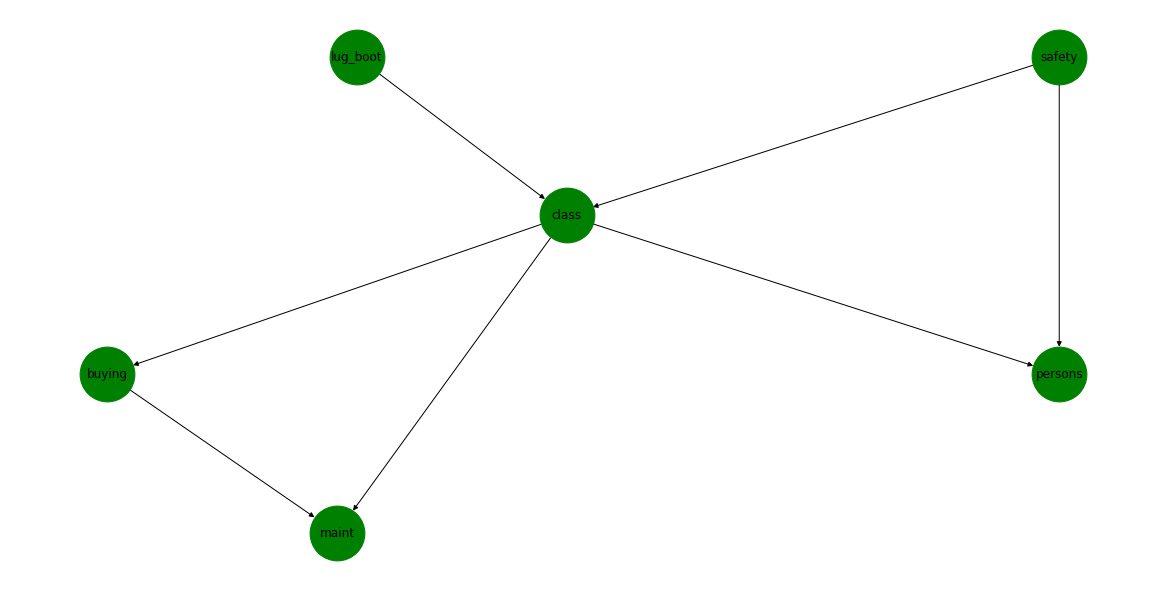

In [32]:
pos = graphviz_layout(model, prog="dot")
plt.figure(figsize=(16, 8))
nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
# plt.savefig('model.png')
plt.show()

### Learning the parameters of the network

As mentioned before, pgmpy currently supports parameter learning only for networks with discrete nodes. There are 2 available methods for determining the values of the conditional probability distributions:
- Maximum Likelihood estimation.

       This method uses relative frequencies for estimating conditional probabilities. However, in case of small datasets it is prone to overfitting.
- Bayesian estimation.

       On the other hand, Bayesian estimator assumes prior CPDs on variables and then updates them using state counts from observed data.
Because our dataset has only 116 samples we use __Bayesian estimation__

In [33]:
model.fit(data=data, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, 2*'\n', 80*"=", '\n')


CPT of buying:
+---------------+-----+-----------------------+
| class         | ... | class(vgood)          |
+---------------+-----+-----------------------+
| buying(high)  | ... | 0.0047169811320754715 |
+---------------+-----+-----------------------+
| buying(low)   | ... | 0.5933962264150944    |
+---------------+-----+-----------------------+
| buying(med)   | ... | 0.39716981132075474   |
+---------------+-----+-----------------------+
| buying(vhigh) | ... | 0.0047169811320754715 |
+---------------+-----+-----------------------+ 


CPT of maint:
+--------------+-----+---------------+
| buying       | ... | buying(vhigh) |
+--------------+-----+---------------+
| class        | ... | class(vgood)  |
+--------------+-----+---------------+
| maint(high)  | ... | 0.25          |
+--------------+-----+---------------+
| maint(low)   | ... | 0.25          |
+--------------+-----+---------------+
| maint(med)   | ... | 0.25          |
+--------------+-----+---------------+
| maint(vhi

Checking if it has errors

In [34]:
model.check_model()

True

Cardinality of all model nodes

In [35]:
model.get_cardinality()

defaultdict(int,
            {'buying': 4,
             'maint': 4,
             'lug_boot': 3,
             'class': 4,
             'safety': 3,
             'persons': 3})

Checking the markov blanket for Classification  and Glucose

In [36]:
print("Markov blanket for variable:")
print("Classification: ", model.get_markov_blanket("Classification"))
print("Glucose: ", model.get_markov_blanket("Glucose"))

Markov blanket for variable:


NetworkXError: The node Classification is not in the digraph.